Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [1]:
%pip install h5py # make sure to install h5py which is used in fixmat.py

Note: you may need to restart the kernel to use updated packages.


Invalid requirement: '#'



In [90]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
from datas.fixmat import *
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [11]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
df, meta = load('datas/etdb_v1.0.hdf5', "Baseline")

In [3]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

In [81]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [96]:
# count fixations per category
num_fix = df.groupby('category').agg({'fix': [np.sum]})
print(num_fix)

# create a dictionary to translate from numbers to meaningful names
mydict = {7:"Natural", 8:"Urban", 10:"Fractals", 11:"Pink noise"}

# rename category column with the dictionary
df["category"] = df["category"].replace(mydict)

# drop rows where the start < 0 or end > 600
df_clean = df.drop(df[(df.start < 0) | (df.end > 600)].index) 

# drop all rows that contain NaN 
df_clean = df_clean.dropna(axis=0, how='any')

#creating duration column
df_clean["duration"] = df_clean["end"]-df_clean["start"]

# remove rows with unrealistic fixation durations
df_clean = df_clean.drop(df_clean[(df_clean.duration < 100) | (df_clean.duration > 400)].index)

# check how many fixations are left for each category
num_fix_category = df_clean.groupby('category')['fix'].agg('count')
print(num_fix_clean)

# mean number of duration and fixation
num_fix_trial = df_clean.groupby('trial')['fix'].agg('count')
duration_trial = df_clean.groupby('trial')['duration'].agg('mean')
print("Mean number of fixations per trial: ",num_fix_trial.mean())
print("Mean duration time across trials: ", duration_trial.mean())

                 fix
                 sum
category            
Fractals    535803.0
Natural     525239.0
Pink noise  369649.0
Urban       603065.0
category
Fractals      2365
Natural       2138
Pink noise    1111
Urban         2850
Name: fix, dtype: int64
Mean number of fixations per trial:  33.1921568627451
Mean duration time across trials:  198.05775


### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

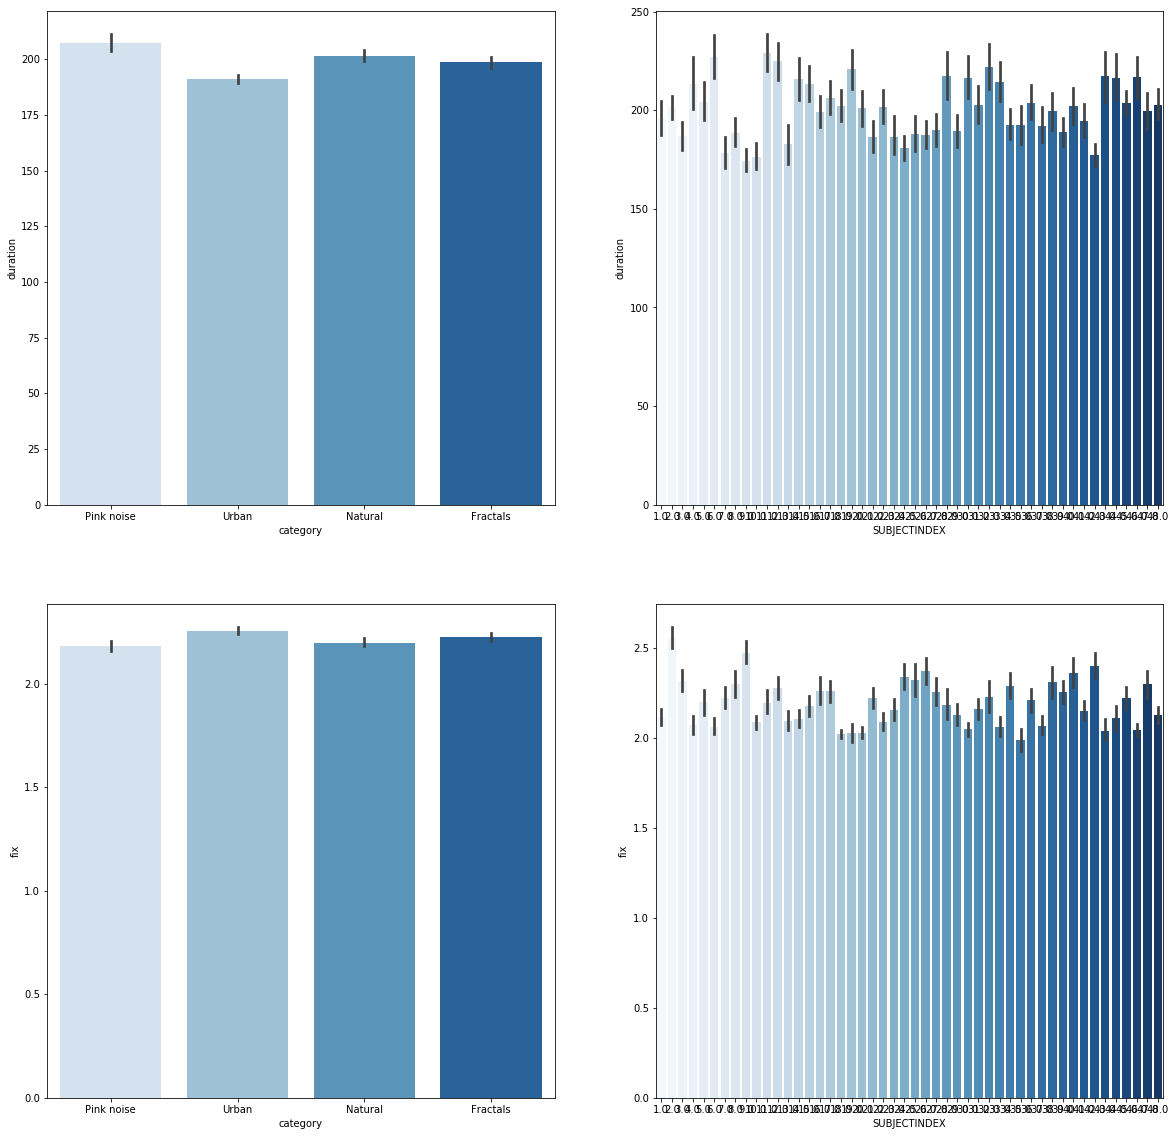

In [69]:
mean_by_category = df_clean.groupby("category").mean()
mean_by_subject = df_clean.groupby("SUBJECTINDEX").mean()

# create figure 
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))

# create plots 
sns.barplot("category", "duration", data = df_clean, palette = "Blues", ax = axs[0,0])
sns.barplot("SUBJECTINDEX", "duration", data = df_clean, palette = "Blues", ax = axs[0,1])
sns.barplot("category", "fix", data = df_clean, palette = "Blues", ax = axs[1,0])
sns.barplot("SUBJECTINDEX", "fix", data = df_clean, palette = "Blues", ax = axs[1,1])

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

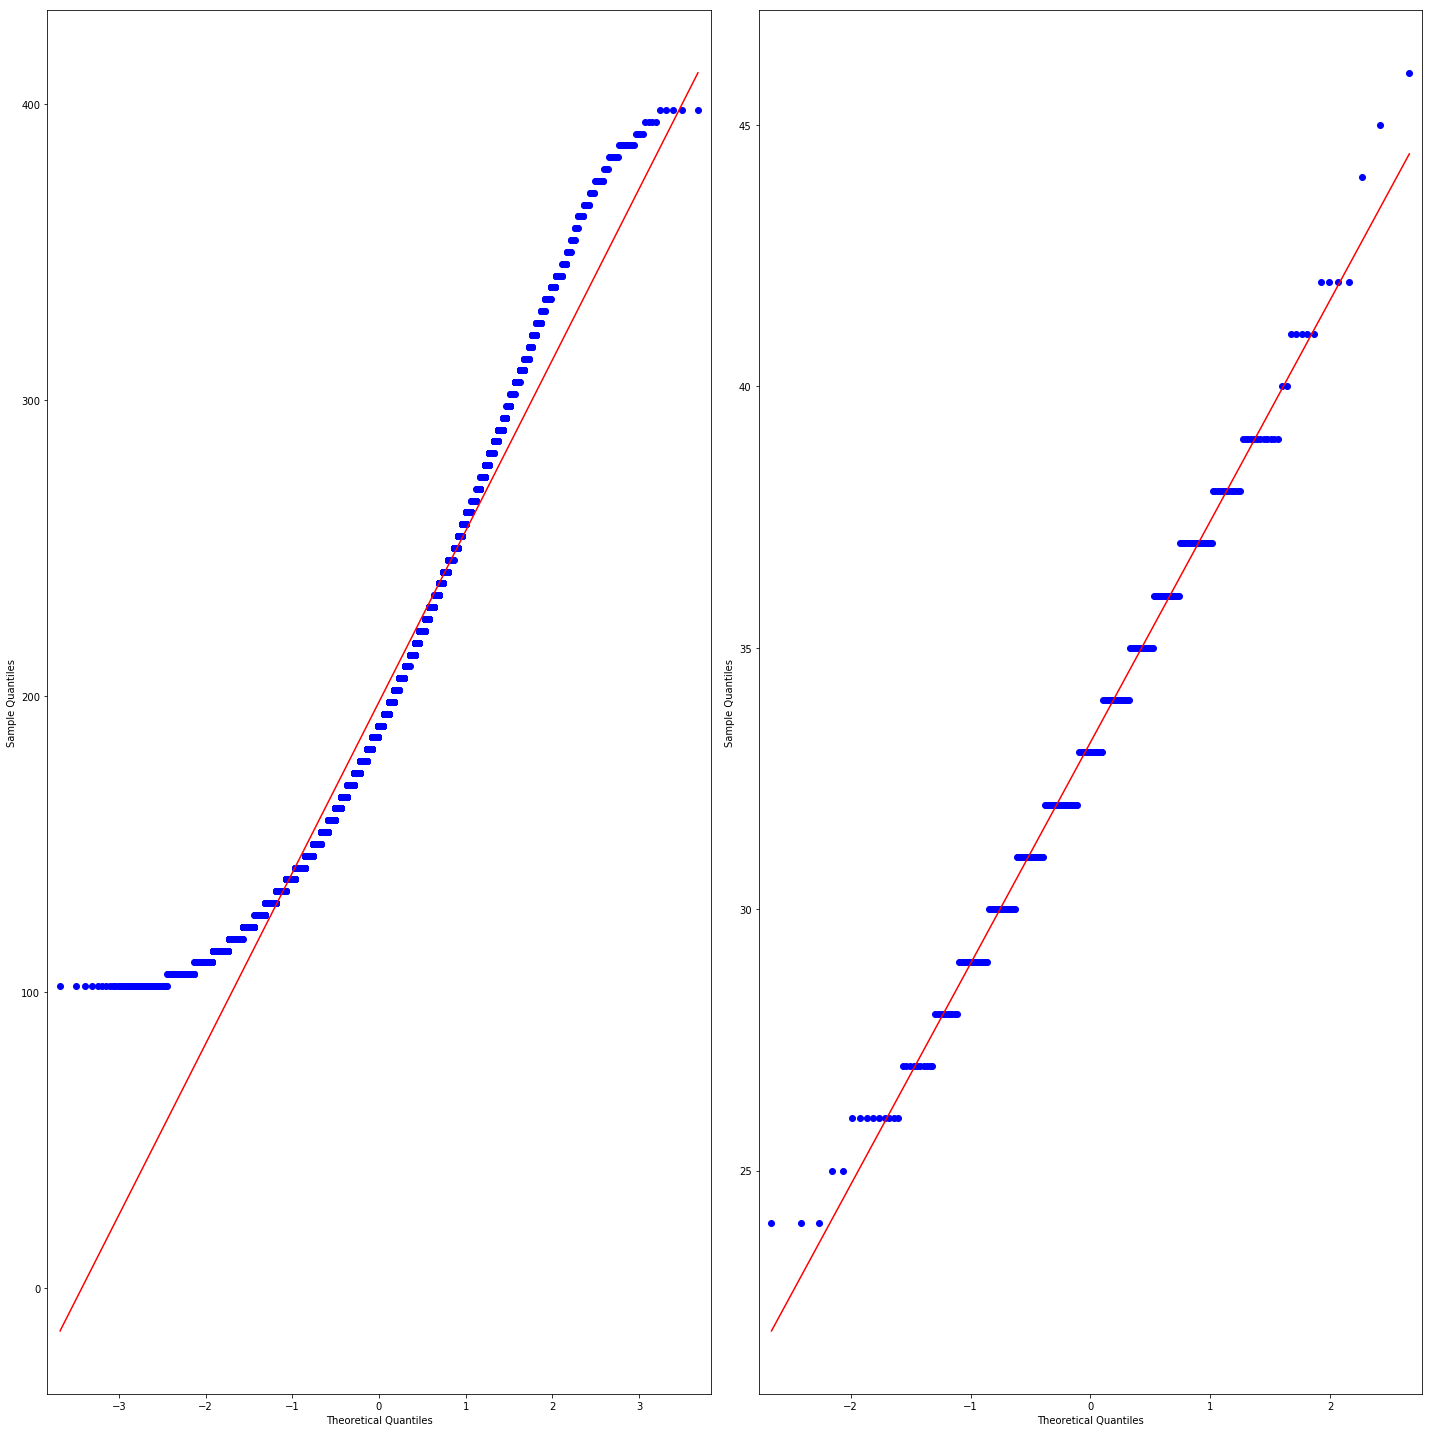

In [88]:
# create a figure with two plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

# compare the duration and the number of fixations per trial with a normal distribution
prob = sm.ProbPlot(df_clean["duration"], dist="norm")
prob.qqplot(line="r", ax=axes[0])
prob = sm.ProbPlot(num_fix_trial, dist="norm")
prob.qqplot(line="r", ax=axes[1])

fig.tight_layout()
plt.show()

what do you think?

Both the fixation duration and the number of fixations per trial seem to be normally distributed. The slight s-shape in the fixation duration is most likely an artifact from removing all durations smaller than 100 and bigger than 400ms.

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [92]:
# H01
# Build the least squared model
duration_results = ols('duration ~ C(category)', data = df_clean).fit()

# Perform the type 1 one-way ANOVA for the two models
duration_anova = anova_lm(duration_results, typ=1)
print("Results for fixation duration: \n", duration_anova)

Results for fixation duration: 
                  df        sum_sq       mean_sq          F        PR(>F)
C(category)     3.0  2.651276e+05  88375.881640  25.644637  1.652442e-16
Residual     8460.0  2.915463e+07   3446.174019        NaN           NaN


In [100]:
# H02
x = num_fix_category
# Build the least squared model
fixation_results = ols('x ~ C(category)', data = num_fix_category).fit()

# Perform the type 1 one-way ANOVA for the two models
fixation_anova = anova_lm(duration_results, typ=1)
print("Results for number of fixation: \n", fixation_anova)

Results for number of fixation: 
                  df        sum_sq       mean_sq          F        PR(>F)
C(category)     3.0  2.651276e+05  88375.881640  25.644637  1.652442e-16
Residual     8460.0  2.915463e+07   3446.174019        NaN           NaN


what do you say?

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


In [7]:
# TODO

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

In [8]:
# TODO

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

In [9]:
# TODO

## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

In [10]:
# TODO

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75